# ForceSMIP Example: Linear Inverse Model

by [Tongtong Xu](https://xutongtong.net/)

#### 1. Introduction
Here we provide an example for estimating the forced signal of the sea surface temperature (`tos`), using a multivariate empirical dynamical approach, the Linear Inverse Model (LIM; [Penland and Sardeshmukh, 1995](https://journals.ametsoc.org/view/journals/clim/8/8/1520-0442_1995_008_1999_togots_2_0_co_2.xml)). The LIM assumes that the time evolution of a climate state can be approximated by the stochastically forced linear dynamical system, where its deterministic operator is derived from the simultaneous and lagged covariances of the climate state. The least damped eigenmode of LIM's operator has been used to extract the forced signal of a climate state, a technique established and applied by several previous studies (e.g., [Penland and Matrosova, 2006](https://doi.org/10.1175/JCLI3951.1); [Solomon and M. Newman, 2012](https://doi.org/10.1038/nclimate1591); [Frankignoul et al, 2017](https://doi.org/10.1175/JCLI-D-17-0009.1); [Xu et al, 2022](https://doi.org/10.1038/s41467-022-34934-x)). Additional information about LIM is also available at [GitHub](https://github.com/Tongtong-Xu-PSL/LIM). 

In the following, relevant functions are introduced step-by-step (section 2). The main script that calls these functions is listed in section 3. In section 4, the notebook is concluded with some questions to be considered.

#### 2. Relevant functions

In [1]:
def ForceSMIP_read(fname,varname):
    # this function reads in the data from netcdf
    # input: fname is a string containing (the path and) the name of the ncfile
    #        varname is a string containing the name of the climate variable to be read, e.g., ""
    # output: a dictionary, containing the 3D climate field, lon & lat in 2D, and time
    
    data = xr.open_dataset(fname)
    
    s = dict()
    s["lon"],s["lat"] = np.meshgrid(data["lon"],data["lat"])
    s[varname] = data[varname].values
    s["mask"] = 1 - 0*s[varname].sum(axis=0)
    s["time"] = data["time"]    
    return s

In [2]:
def ForceSMIP_removeSeas(z,time):
    # this function removes the seasonal mean climatology
    # input: z is the 3D climate field [time, lat, lon], time is the time series (xarray format)
    # output: seasonal mean fields (seas in [season, lat, lon]), and anomalies in the same size as z
    
    monlist = time.dt.month.values
    T, J, I = z.shape

    # get seasonality matrices
    seas = np.zeros((12, J, I))
    for i in range(1, 13):
        loc = monlist == i
        seas[i-1, :, :] = np.mean(z[loc, :, :], axis=0)

    # get anomaly after removing seasonality
    ano = np.zeros_like(z)
    for i in range(1, 13):
        loc = monlist == i
        ano[loc, :, :] = z[loc, :, :] - seas[i-1, :, :]
    return seas,ano

In [3]:
def ForceSMIP_XYT_into_ZT(z,mask):
    # convert 3D array into 2D, such that the climate field is represented in [time, space]
    # input: z is the 3D array of [time, lat, lon], mask is the 2D array of [lat,lon], containing either 1 or nan
    
    T, J, I = z.shape
    z = np.multiply(z,np.tile(mask[np.newaxis,:,:], (T, 1, 1)))
    z = z.reshape(T,J*I)
    idx = np.where(~np.isnan(z[0, :]))[0]
    zout = z[:,idx]
    return zout

def ForceSMIP_ZT_into_XYT(z,mask):
    # convert 2D array back to 3D, such that the climate field is represented in [time, lat, lon]
    # input: z is the 2D array of [time, space], mask is the 2D array of [lat,lon], containing either 1 or nan
    
    J, I = mask.shape
    T, _ = z.shape
    idx = np.where(~np.isnan(mask.reshape(J*I)))[0]
    zout = np.zeros((T,J*I))
    zout[:,idx] = z
    zout = np.multiply(zout.reshape(T,J,I),np.tile(mask[np.newaxis,:,:], (T, 1, 1)))
    return zout

In [4]:
def ForceSMIP_EOF(A):
    # EOF analysis of the climate field, note that the climate field has to be in 2D format [time, space]
    # output: a dictionary, containing EOF in [mode, space], PC in [time, mode], lamb is the portion of explained variance by each PC
    
    norm = np.sqrt(np.mean(np.mean(A**2, axis=0)))
    A = A/norm
    
    U, S, V = np.linalg.svd(A, full_matrices=False)

    s = dict()
    s["EOF"] = V
    s["PC"] = np.dot(A, s["EOF"].T)
    D = S ** 2
    s["D"] = D / np.sum(D)
    s["norm"] = norm
    return s

In [5]:
def ForceSMIP_lim_trend(X,tau0):
    # derive the LIM based trend
    # input: X is 2D field in [mode, time], tau0 is the training lag
    # output: u, the spatial pattern of the least damped mode; alpha, the time series associated with the least damped mode;
    #         X_least_damped is in [mode, time], the trend representation in PC space

    X0 = X[:,:-tau0]
    Xtau = X[:,tau0:]

    C0 = np.dot(X0, X0.T) / (X0.shape[1] - 1)
    Ctau = np.dot(Xtau, X0.T) / (X0.shape[1] - 1)

    # linear operator
    G = np.dot(Ctau,np.linalg.pinv(C0))
    D,U = np.linalg.eig(G)
    D = np.log(D)/tau0
    V = np.linalg.inv(U).T

    # sort modes
    loc = np.argsort(-np.real(D))
    sigma = -1 / np.real(D[loc])
    UU = U[:, loc]
    VV = V[:, loc]

    # identify the least damped mode
    u = UU[:, 0]
    v = VV[:, 0]
    alpha = np.dot(v, X)

    X_least_damped = np.real(np.outer(u, alpha))
    return u, alpha, X_least_damped

In [6]:
def ForceSMIP_plot_map(z,data):
    # this function plots the global spatial map
    # z is the map to be plotted, data is the dictionary containing (at least) lon, lat in 2D,
    # as well as the mask; size of z, lon, lat, mask must match
    level = np.nanmax(z)
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

    im = ax.contourf(data["lon"], data["lat"], np.multiply(z,data["mask"]), levels=np.linspace(-level, level, 11),
                transform=ccrs.PlateCarree(),
                cmap=plt.cm.RdBu_r,extend='both')
    ax.coastlines()
    ax.set_global()
    ax.set_extent([np.min(data["lon"]),np.max(data["lon"]),np.min(data["lat"]),np.max(data["lat"])],crs=ccrs.PlateCarree())
    fig.colorbar(im)

In [7]:
def ForceSMIP_plot_index(field,trend,time):
    # this function plots the time series
    # field is the 2D climate field in [time, space]
    # trend is the 2D trend estimate in [time, space]
    # time is in (xarray format)
    
    field = data2D

    f = np.mean(field, axis=1)
    t = np.mean(trend, axis=1)

    plt.figure(figsize=(7, 4.5))  
    plt.plot(data['time'], f, linewidth=1, color=[0.6, 0.6, 0.6])
    plt.plot(data['time'], t, linewidth=3)
    plt.legend(['Global mean', 'Trend'], loc='upper left')
    plt.tight_layout()

#### 3. Main script

In [8]:
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# -----To be Change-----
fname = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Training/Omon/tos/CESM2/tos_mon_CESM2_historical_ssp370_r1011.001i1p1f1.188001-202212.nc" # NCAR path
# fname = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/Evaluation-Tier1/Omon/tos/tos_mon_1H.195001-202212.nc" # ETH path
varname = "tos" # climate field of interest
pcnum = 8 # EOF truncation relevant to LIM (how many EOFs are kept?)
# ----------------------

# READ data
data = ForceSMIP_read(fname,varname)

# REMOVE SEASONAL MEAN
data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])

# EOF ANALYSIS
data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
pca = ForceSMIP_EOF(data2D)

In [9]:
print(pca['EOF'].shape)
print(pca['PC'].shape)


(1716, 7054)
(1716, 1716)


In [10]:
pca['PC']

array([[-3.08563480e+01,  4.18725892e+01, -7.10171766e+00, ...,
        -3.48896259e-16,  2.53333053e-14,  5.50774704e-16],
       [-2.66448772e+01,  3.91184548e+01, -6.96056036e+00, ...,
        -2.65651216e-14, -1.74786943e-14, -6.42671680e-15],
       [-1.89951135e+01,  3.37051266e+01, -1.45619581e+01, ...,
        -1.05666344e-15, -4.10662173e-14, -8.21651774e-15],
       ...,
       [-4.83792605e+01, -7.44773174e+01, -1.43165907e+01, ...,
        -3.92914867e-14, -3.15128782e-14,  2.08045386e-14],
       [-4.61743800e+01, -7.68388873e+01, -1.50409439e+01, ...,
         3.72683655e-14, -1.16405366e-14, -7.38992201e-16],
       [-4.08568846e+01, -7.54646806e+01, -1.61530598e+01, ...,
         3.28439533e-14, -2.28515123e-14,  2.12217396e-14]])

In [11]:
# LIM based trend estimate
# Note: for multiple variables, we typically construct a state vector X that consists of the leading 
# PCs of all variables.
X = pca["PC"][:,0:pcnum].T # transpose into a format of [mode, time]

In [12]:
X.shape

(8, 1716)

# Mi libraries

In [13]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
##from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [14]:
import scipy.linalg as sc
import numpy.linalg as lin

In [15]:
import os
from typing import (
    TYPE_CHECKING,
    Any,
    Callable,
    Dict,
    Hashable,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    TypeVar,
    Union,
    cast,
)

# Functions

## Zapata computation

In [16]:
def anomaly(var,option='anom',freq='month'):
    """
    Compute Anomalies according to *option*

    Long description here.

    Parameters
    ----------
    var :   xarray
        array to compute anomalies
    option :
        Option controlling the type of anomaly calculation  
            =============     ==========================================================
            deviation         Subtract the time mean of the time series
            deviation_std     Subtract the time mean and normalize by standard deviation
            anom              Compute anomalies from monthly climatology    
            anomstd           Compute standardized anomalies from monthly climatology
            =============     ==========================================================
    freq :  
        Frequency of data   

    Returns
    -------
    anom :  xarray

    """

    frequency = 'time.' + freq
    if option == 'deviation':
        anom = var - var.mean(dim='time')
    elif option == 'deviation_std':
        anom = (var - var.mean(dim='time'))/var.std(dim='time')
    elif option == 'anom':
        clim = var.groupby(frequency).mean("time")
        anom = var.groupby(frequency) - clim
    elif option == 'anomstd':
        clim = var.groupby(frequency).mean("time")
        climstd = var.groupby(frequency).std("time")
        anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                var.groupby(frequency),
                clim,
                climstd )
    else:
        print(' Wrong option in `anomaly` {}'.format(option))
        raise SystemExit

    return anom

In [17]:
class Xmat():
    """ This class creates xarrays in vector mathematical form.

    The xarray is stacked along `dims` dimensions
    with the spatial values as column vectors and time as the 
    number of columns.

    Specifying the parameter `option` as `DropNaN` will drop all the NaN values
    and the matrix can then be recontructed using the `expand` method.
    

    Parameters
    ----------
    X : xarray
        `xarray` of at leasts two dimensions
    dims : 
        Dimensions to be stacked, *Default ('lat','lon')*
    options :
        Options for Xmat creation
        None :  Keep NaN (Default)
        DropNaN : Drop NaN values

    Attributes
    ----------
    A : xarray
        Stacked matrix of type *xarray*
    _ntime  :
        Length of time points
    _npoints :
        Length of spatial points
    _F : xarray
        Original matrix of type *xarray* with only NaN values 
    
    Examples    
    --------    
    Create a stacked data matrix along the 'lon' 'lat'  dimension

    >>> Z = Xmat(X, dims=('lat','lon'))

    """

    __slots__ = ('A','_F','_ntime','_npoints','_opt')

    def __init__(
        self,
        X,
        dims: Union[Hashable, Sequence[Hashable], None] = None,
        option=None,
        ):

        if not dims:
            SystemError('Xmat needs some dimensions')
            
        self._F = xr.full_like(X,fill_value=np.nan)
        self._opt = option
        self.A = X.stack(z=dims).transpose()
        self._ntime = len(X.time.data)
        self._npoints = len(X.stack(z=dims).z.data)
        print(' Created mathematical matrix A, \n \
                stacked along dimensions {} '.format(dims))
        if self._opt == 'DropNaN':
            self.A = self.A.dropna(dim='z')
            print(' Creating Matrix with Drop NaN values')
           

    def __call__(self, v ):
        ''' Matrix vector evaluation.'''
        f = self.a @ v
        return f

    def __repr__(self):
        '''  Printing Information '''
        print(' \n Math Data Matrix \n {} \n'.format(self.A))
        print(f' Shape of A numpy array {self.A.shape}')
        return  '\n'
    
    def expand(self):
        '''
        Unroll Xmat matrix to xarray

        Examples    
        --------    
        Unroll a stacked and NaN-dropped matrix `X`

        >>> Xlatlon = X.expand()
        '''

        if self._opt == 'DropNaN':
            Aloc =  self.A.unstack()
            self._F.loc[{'lat':Aloc.lat,'lon':Aloc.lon}] = Aloc
            return self._F
        else:
            return self.A.unstack() 
     
    def svd(self, N=10):
        '''Compute SVD of Data Matrix A.
        
        The calculation is done in a way that the modes are equivalent to EOF

        Parameters
        ----------
        N :  
            Number of modes desired.     
            If it is larger than the number of `time` levels    
            then it is set to the maximum

        Returns
        -------
        out : dictionary
            Dictionary including 
                =================     ==================  
                Pattern               EOF patterns    
                Singular_Values       Singular Values 
                Coefficient           Time Coefficients   
                Varex                 Variance Explained  
                =================     ==================
        Examples         
        --------     
        >>> out = Z.svd(N=10) 

        '''
        #Limit to maximum modes to time levels
        Neig = np.min([N,self._ntime])
        print(f'Computing {Neig} Modes')
        # Prepare arrays
        len_modes = self._ntime
        u = self.A.isel(time=range(Neig)).rename({'time': 'Modes'}).assign_coords(Modes= range(Neig))
        u.name = 'Modes'
        
        #Compute modes
        _u,_s,_v=sc.svd(self.A,full_matrices=False)
    
        #EOF Patterns
        u.data = _u[:,0:Neig]
        #Singular values
        s = xr.DataArray(_s[0:Neig], dims='Modes',coords=[np.arange(Neig)])
        #Coefficients
        vcoeff = xr.DataArray(_v[0:Neig,:], dims=['Modes','Time'],coords=[np.arange(Neig),self.A.time.data])
        # Compute variance explained
        _varex = _s**2/sum(_s**2)
        varex = xr.DataArray(_varex[0:Neig], dims='Modes',coords=[np.arange(Neig)])

        #Output
        out = xr.Dataset({'Pattern':u,'Singular_Values': s, 'Coefficient': vcoeff, 'Varex': varex})
        return out

    def corr(self,y, Dim =('time') , option = None):
        """
        Compute correlation of data matrix `A` with index `y`.

        This method compute the correlation of the data matrix
        with an index of the same length of the `time` dimension of `A`

        The p-value returned by `corr` is a two-sided p-value.  For a
        given sample with correlation coefficient r, the p-value is
        the probability that the absolute value of the  correlation of a random sample x' and y' drawn from
        the population with zero correlation would be greater than or equal
        to the computed correlation. The algorithms is taken from scipy.stats.pearsonsr' that can be consulted for full reference

        Parameters
        ----------
        y : xarray  
            Index, should have the same dimension length `time` 

        option : str
            * 'probability' _Returns the probability (p-value) that the correlation is smaller than a random sample
            * 'signicance'  _Returns the significance level ( 1 - p-value)
        
        Returns
        -------
        According to `option`   

        * None  
            corr :  Correlation array  

        * 'Probability'     
            corr :  Correlation array   
            prob :  p-value array  

        * 'Significance'    
            corr :  Correlation array   
            prob :  Significance array  
        
        Examples
        --------
        Correlation of data matrix `Z` with `index`

        >>> corr = Z.corr(index)
        >>> corr,p = Z.corr(index,'Probability')
        >>> corr,s = Z.corr(index,'Significance')
        """
        index= y - y.mean(dim=Dim)
        _corr = (self.A - self.A.mean(dim=Dim)).dot(index)/    \
               (self.A.std(dim=Dim) * y.std(dim=Dim))/self._ntime

        # The p-value can be computed as
        #     p = 2*dist.cdf(-abs(r))
        # where dist is the beta distribution on [-1, 1] with shape parameters
        # a = b = n/2 - 1.  `special.btdtr` is the CDF for the beta distribution
        # on [0, 1].  To use it, we make the transformation  x = (r + 1)/2; the
        # shape parameters do not change.  Then -abs(r) used in `cdf(-abs(r))`
        # becomes x = (-abs(r) + 1)/2 = 0.5*(1 - abs(r)).  

        if option == 'Probability':
            ab = self._ntime/2 - 1
        # Avoid small numerical errors in the correlation
            _p = np.maximum(np.minimum(_corr.data, 1.0), -1.0)
            p = 2*sp.btdtr(ab, ab, 0.5*(1 - abs(_p)))
        
            prob = self.A.isel(time=0).copy()
            prob.data = p
            return _corr , prob
        elif option == 'Significance':
            ab = self._ntime/2 - 1
        # Avoid small numerical errors in the correlation
            _p = np.maximum(np.minimum(_corr.data, 1.0), -1.0)
            p = 2*sp.btdtr(ab, ab, 0.5*(1 - abs(_p)))
        
            prob = self.A.isel(time=0).copy()
            prob.data = 1. - p
            return _corr , prob
        else:
        # return only correlation
            return _corr
    
    def cov(self,y, Dim =('time') ):
        """
        Compute covariance of data matrix `A` with `index`.

        This method compute the correlation of the data matrix
        with an index of the same length of the `time` dimension of `A`

        Examples
        --------
        Covariance of data matrix `Z` with `index`

        >>> cov = Z.cov(index)

        """
        index= (y - y.mean(dim=Dim))
        _cov = (self.A - self.A.mean(dim=Dim)).dot(index)/self._ntime
        return _cov

    def anom(self,**kw):
        """ 
        Creates anomalies.

        This is using the function `anomaly` from `zapata.computation` 
        
        """

        self.A = anomaly(self.A,**kw)
        return

    def detrend(self,**kw):
        '''
        Detrend data using the function scipy.signal.detrend
        '''
        print(f'Detrending data with options -->  {kw}')
        self.A.data = sig.detrend(self.A.data,**kw)
        return


## Zapata Koopman

In [18]:
from scipy.spatial import distance

import klus.algorithms as al
import klus.kernels as kernels
import klus.tools as tools

class Koop():
    """ This class creates the Koopman operator

    The input array is supposed to be in features/samples form
    The augemnted matrix is created inside

    Parameters
    ----------
    vdat: array 
        Data array with features and samples
    
    **kwargs : dict
        * 'operator'          Choice of operator `Koopman` or `Perron` 
        * 'deltat'            Time interval between samples
        * 'kernel_choice'     Kernel choice , `gauss`,`poly`
        * 'sigma'             Bandwidth for Gaussian kernel
            * 'std'   -- Standard Deviation of distances
            * 'median -- Median of distances
            * '100'   -- Explicit value
        * 'epsilon'             Regularization parameter 
        * 'maxeig'     Max number of eigenvalues to compute
        * 'poly_order': 1     Order of polynomial kernel
        * 'poly_shift':0      Shift of polynomial kernel 

    Attributes
    ----------
    PsiX : numpy array
        Reduced data matrix of type *array*
    PsiY : numpy array
        Shifted data matrix of type *array*
    ntime  : int
        Number of samples or time points
    npoints : int
        Number of features or spatial points
    deltat : float
        Time interval between samples
    operator: str
        Operator chosen {'Koopman', 'Perron'}
    kernel_choice: object
        Kernel used in the estimator
    epsilon : float
        Tikhonov Regularization parameter {1e-5}
    sigma : float
        Bandwidth for Gaussian kernel
    maxeig : int
        Maximum number of eigenvalues to compute
    poly_order: int
        Order polynomial kernel
    poly_shift: float
        Shift polynomial kernel
    ww: array
        Koopman eigenvalues
    wwg: array
        Koopman generator eigenvalues
    cc: array
        Koopman eigenfunctions coefficients
    vv: array
        Koopman eigenfunction values on the samples
    wf: array
        Filtered Koopman eigenvalues
    wfg: array
        Filtered Koopman generator eigenvalues
    vvf: array
        Filtered Koopman eigenfunction values on the samples
    Gxx: array
        Kernel Matrix Gxx
    Gxy: array
        Kernel Matrix Gxy
    ker: object
        Object Kernel used
    time_data:
        Time array (optional)

    Examples    
    --------    
    Create a Koopman operator 

    >>> K = Koop(X, {operator: 'koopman', 
            kernel_choice : 'gauss', sigma : 42, epsilon : 1e-5})

    """

    __slots__ = ('PsiX','PsiY','ntime','npoints', 'operator', 'deltat','time_data',\
                'kernel_choice','epsilon','sigma','maxeig','bandwidth',\
                'poly_order','poly_shift', 'k_shift',\
                'wf','wfg','vvf',\
                'ww','wwg','vv','cc','Gxx','Gxy','ker')
    

    def __init__(
        self,
        vdat,
        **kwargs ):
        
        #Set default arguments
        defaultOptions = {'operator': 'Koopman', 'deltat':1,
            'kernel_choice' : 'gauss', 'bandwidth' : 'std', 'epsilon' : 1e-5, 'maxeig':3000,
            'poly_order': 1,'poly_shift':0,'k_shift':0.0, 'time_data': None}
        options ={**defaultOptions, **kwargs}
        
        self.PsiX = vdat[:,:-1]
        '''Reduced Data matrix of type (`array`)'''
        self.PsiY = vdat[:,1:]
        '''Shifted data matrix of type (`array`)'''
        self.ntime = self.PsiX.shape[1]
        '''Number of samples or time points (`int`)'''
        self.npoints = self.PsiX.shape[0]
        '''Number of features or spatial points (`int`)'''
        self.deltat = 1
        '''Time interval between samples (`float`)'''
        
        self.bandwidth = None
        '''Option Bandwidth for Gaussian kernel (`str`)'''
        self.sigma = None
        '''Bandwidth for Gaussian kernel (`float`)'''
        self.operator = options['operator']
        '''Operator chosen (`str`) {'Koopman', 'Perron'}'''
        self.kernel_choice = options['kernel_choice']
        '''Kernel used in the estimator (`str`)'''
        self.epsilon = options['epsilon']
        '''Tikhonov Regularization parameter (`float`) {1e-5}'''
        self.maxeig = options['maxeig']
        '''Maximum number of eigenvalues to compute (`int`)'''
        self.poly_order = options['poly_order']
        '''Order polynomial kernel (`int`)'''
        self.poly_shift = options['poly_shift']
        '''Shift polynomial kernel (`float`)'''
        self.k_shift = options['k_shift']
        '''Shift  kernel (`float`)'''
        if options['time_data'] is not None:
            self.time_data = options['time_data']
        else:
            self.time_data = np.arange(self.ntime)
        '''Time array (`array`)'''

        print(f'Created {self.operator} Estimator \n for {self.ntime} samples and {self.npoints} features, \
            {self.deltat} time interval' )

        self.wf = None
        '''Filtered Koopman eigenvalues (`array`)'''
        self.wfg = None
        '''Filtered Koopman generator eigenvalues (`array`)'''
        self.vvf = None
        '''Filtered Koopman eigenfunction values on the samples (`array`)'''

        self.ww = None
        '''Koopman eigenvalues (`array`)'''
        self.wwg = None
        '''Koopman generator eigenvalues (`array`)'''
        self.vv = None
        '''Koopman eigenfunction values on the samples (`array`)'''
        self.cc = None
        '''Koopman eigenfunctions coefficients (`array`)'''
        self.Gxx = None
        '''Kernel Matrix Gxx (`array`)'''
        self.Gxy = None
        '''Kernel Matrix Gxy (`array`)'''
        self.ker = None
        '''Kernel used (`object`)'''

    def __call__(self, v ):
        ''' Not implemented'''
        print('Not implemented')
        return 

    def __repr__(self):
        '''  Printing Information '''
        print(f'Koopman Estimator for operator {self.operator} with paramenters:\n \
                Kernel_choice {self.kernel_choice}\n \
                Maxeig {self.maxeig}\n \
                Epsilon {self.epsilon}  \n ')
        if self.kernel_choice == 'poly':
            print(f' Poly_Order {self.poly_order} \n \
                     Poly_Shift {self.poly_shift}\n ')
        elif self.kernel_choice == 'gauss':
            print(f'  Bandwidth {self.sigma}\n \
                      ')
        return '\n'

    
    def fit(self,bandwidth=None, condition= 1e-15):               #taken from zapata vecchio
        ''' 
        Fitting estimator.
        Select bandwidth with `bandwidth`

        Parameters
        ----------
        bandwidth: string
            Select the bandiwidth for the Gaussian kernel
                * 'std'             Use bandwidth that make the distances of std 1
                * 'median'          Use median value of distances
                * '100'             Use this explicit numerical value    
                
        Returns
        -------  
        ww:
            Eigenvalues
        self.wwg = np.log(ww_tot)/self.deltat:
            Generator Eigenvalues
        self.vv:
            Value of Eigenfunctions at samples
        self.Gxx:
            kernel matrix Gxx
        self.Gxy:
            kernel matrix Gxy
        self.ker:
            Kernel used

        '''
        condition = condition            #changed, 1e-15 for newer paper,     1e-5 older navarra paper

        
        if self.operator == 'Perron': 
            ops='P'
        elif self.operator =='Koopman':
            ops='K'
        else:
            raise ValueError('TRANSFER_OP_GAUSS:  --- Wrong Operator choice ')
        print(' Calculating {} Operator '.format(self.operator))

        self.bandwidth = bandwidth

        if bandwidth is None or bandwidth == 'std':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale=np.std(similarity.flatten())
        elif bandwidth == 'median':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale = np.median(similarity.flatten())
        else:
            scale = 2*(float(bandwidth))**2
       
        self.sigma = np.sqrt(scale/2)
        print(f'Using option {bandwidth} for a  {scale} and sigma {self.sigma}\n')

        if self.kernel_choice == 'gauss':
            k = kernels.gaussianKernel(self.sigma)
        elif self.kernel_choice == 'poly':
            k = kernels.polynomialKernel(p=self.poly_order,c=self.poly_shift)
        elif self.kernel_choice == 'gaussShifted':
            k = kernels.gaussianKernelShifted(self.sigma, shift=self.k_shift)
        else:
            raise ValueError(f'KK_fit:  --- WrongKernel choice {self.kernel_choice}')
        
        ww_tot,vv_tot,cc_eig,A,Gxx,Gxy =al.kedmd(self.PsiX,self.PsiY, k, \
                epsilon=self.epsilon, evs=self.maxeig, operator=ops,kind='kernel',cond=condition)
        
        print(f'Computed Transfer Eigenvalues')
        self.ww = ww_tot
        self.wwg = np.log(ww_tot)/self.deltat
        self.vv = vv_tot
        self.cc = cc_eig
        self.Gxx = Gxx
        self.Gxy = Gxy
        self.ker = k

        return 
    
    def order(self,choice='frequency',direction='down',cut_period=3):
        ''' 
        Order Eigenvalues according to `option`

        Parameters
        ----------
        option:
            * 'magnitude'         abs(w)
            * 'frequency'         w.imag
            * 'growth'            log(w).real/dt
            * 'ones'              abs(w) closest to 1.0
            * 'stable'            log(w).real/dt irrespextive of sign 
        
        direction:
            * 'up'               descending
            * 'down'             ascending
        
        cut_period:
            Eliminate modes with shorter periods (sample units)
        
        Returns
        -------

        wf:
            Ordered Koopman Eigenvalues
        wfg:
            Ordered generator eigenvalues
        vvf:
            Ordered Koopman eigenfunctions
            
        '''

        #  cut period in (months)

        if cut_period is not 0:
            wmax = np.max(np.where(2*math.pi/self.wwg.imag > cut_period))
        else:
            wmax = len(self.wwg.imag)

        _wf =self.ww[0:wmax]
        _vvf = self.vv[:,0:wmax]
        print(f'Eliminating frequency higher than {cut_period} months, \
            original modes {len(self.ww)}, remaining {len(_wf)}')
        
        wf,wfg, indf = order_w(_wf,option=choice,direction=direction,tdelta=self.deltat)

        self.wf = wf
        self.wfg = wfg
        self.vvf = _vvf[:,indf]

        return wf, wfg, self.vvf
    
    def eigone(self,ww,vv,tol=0.1,select='one',verbose=True):
    
        '''  
        Choose stable eigenvalues, either according their absolute value
        or according the sign of the real part

        Parameters
        ----------

        ww: complex
            Koopman Eigenvalues
        vv: array complex
            Koopman eigenfunctions
        select:
            * `one`       Eigenvalues close to one in Abs less than `tol`
            * `stable`    Real part < 0
            * `unstable`  Real part > 0
        tol:
            Tolerance
        verbose:
            Print Diagnostics
        

        Returns
        -------

        ww:
            Selected eigenvalues
        vv:
            Selected eigenfunctions
        ind:
            Index of selected eigenvalues
        '''
        
        print(f'Keeping only EI close to unity less than tol {tol}')

        indone = choose_eig(select,ww,tol,self.deltat)
        N1 = len(indone)
        wone = ww[indone]
        print(f'\n Trace of generator eigenvalues close to unity according to tolerance {tol} --->  {sum(np.log(wone))}')
        print(f' Factor of Phase Volume contraction {np.exp(sum(np.log(wone))):.6f} per month\n')
        # Order retained unitary eigenvalues and obtain generator eigenvalues 'expwr'
        print(f'Number of Eigenvalues found {N1} over {len(ww)} for kmode tol {tol}\n\n')
        # _,expwr,indexpwr = order_w(wone,option='stable',direction='down',tdelta=1)

        headr = ('Mode','Real Eig','Im Eig','Abs','Gen Real (Yr)','Gen Imag (Yr)')
        kaz_data = [(i,wone[i].real, wone[i].imag, abs(wone[i]), 1./np.log(wone[i]).real/12,   2*math.pi/np.log(wone[i]).imag/12) for i in range(min(len(wone),50))]
        if verbose:
            print(tab.tabulate(kaz_data, headr,stralign='center',tablefmt='github'))
        _vv = vv[:,indone]

        return wone,_vv,indone

    def compute_modes(self,ww,vv,modetype='',description='',normalization=False):
        import math
        '''
        Compute Koopman Modes
        
        Parameters
        ----------
        
        ww:
            Koopman eigenvalues
        vv:
            Value of Koopman EIgenfunctions at samples
        modetype:
            Descriptive label 
        description:
            Data Descritpion
        normalization:
            If `False` (Default) the eigenfunctions are not normalized, se to`True`
            to get Koopman modes over normalized eigenfunctions.
        
        
        Returns
        -------
        
        ds : data set
            .. table:: Content for `ds`
               :widths: auto

               ======================        ============================================
               Variable                      Description
               ======================        ============================================
               keig(time,modes)              Normalized Koopman eignfunction values at sample points
               kmodes(features,modes)        Koopman modes
               periods                       Periods of Koopman modes
               eigenvalues                   Koopman Eigenvalues
               ======================        ============================================
        '''
        
        Nmodes = vv.shape[1]
        Ntimes = self.ntime 
        Nfeatures = self.npoints

        # Normalize Koopman eigenfunctions
        if normalization:
            vvnorm = sc.norm(vv,axis=0)
            vnormalized = vv@np.diag(1./vvnorm)
        else:
            vnormalized = vv

        # The ordering is consistent with Mezic
        Phiinv, vrank = sc.pinv(vnormalized,return_rank=True)
        KMM = Phiinv@(self.PsiX.T)
        print(f'Computed Kmodes {KMM.shape} for {vv.shape} normalized eigenfunctions')
        print(f'Computed Kmodes {Nmodes} {Nfeatures} vv  {Ntimes} {Nmodes} eigenfunctions')
        print(f'Rank of V matrix {vrank}')
        

        # Create Data Sets for Koopman modes
        ds = xr.Dataset(
            data_vars=dict(
            kmodes=(["x", "modes"], KMM.T),
            eigfun=(["time", "modes"], vnormalized),
            periods=(["modes"],  2*math.pi/np.log(ww).imag/12),
            eigval=(["modes"],  ww )                                 ),

        coords=dict(
            feature=(["x"], np.arange(Nfeatures)),
            time=(["time"], self.time_data),
            modes=(["modes"], np.arange(Nmodes) ) ),
        attrs=dict(type=modetype, description=description)  )

        return ds
    
    def compute_modes_y(self,ww,vv,modetype='',description='',normalization=False):
        '''
        Compute Koopman Modes
        
        Parameters
        ----------
        
        ww:
            Koopman eigenvalues
        vv:
            Value of Koopman EIgenfunctions at samples
        modetype:
            Descriptive label 
        description:
            Data Descritpion
        normalization:
            If `False` (Default) the eigenfunctions are not normalized, se to`True`
            to get Koopman modes over normalized eigenfunctions.
        
        
        Returns
        -------
        
        ds : data set
            .. table:: Content for `ds`
               :widths: auto

               ======================        ============================================
               Variable                      Description
               ======================        ============================================
               keig(time,modes)              Normalized Koopman eignfunction values at sample points
               kmodes(features,modes)        Koopman modes
               periods                       Periods of Koopman modes
               eigenvalues                   Koopman Eigenvalues
               ======================        ============================================
        '''
        
        Nmodes = vv.shape[1]
        Ntimes = self.ntime 
        Nfeatures = self.npoints

        # Normalize Koopman eigenfunctions
        if normalization:
            vvnorm = sc.norm(vv,axis=0)
            vnormalized = vv@np.diag(1./vvnorm)
        else:
            vnormalized = vv

        # The ordering is consistent with Mezic
        Phiinv, vrank = sc.pinv(vnormalized,return_rank=True)
        KMM = Phiinv@(self.PsiY.T)
        print(f'Computed Kmodes {KMM.shape} for {vv.shape} normalized eigenfunctions')
        print(f'Computed Kmodes {Nmodes} {Nfeatures} vv  {Ntimes} {Nmodes} eigenfunctions')
        print(f'Rank of V matrix {vrank}')
        

        # Create Data Sets for Koopman modes
        ds = xr.Dataset(
            data_vars=dict(
            kmodes=(["x", "modes"], KMM.T),
            eigfun=(["time", "modes"], vnormalized),
            periods=(["modes"],  2*math.pi/np.log(ww).imag/12),
            eigval=(["modes"],  ww )                                 ),

        coords=dict(
            feature=(["x"], np.arange(Nfeatures)),
            time=(["time"], self.time_data),
            modes=(["modes"], np.arange(Nmodes) ) ),
        attrs=dict(type=modetype, description=description)  )

        return ds

    def reconstruct_koopman(self,ds,decode=None,select_modes=None):
        '''
    
        Reconstruction of data from Koopman modes
        
        Parameters
        ----------
       
        ds:
            Koopman decomposition from `compute_modes`
        
        decode:
            Array decoding features
            
        decode: 
            If not empty contains the array for decoding
            to physical space
        
        select_modes: list
            If not empty reconstrut using only selected modes
            [2,7,4]
            

            
        Returns
        -------
        
        data : Array
            Reconstructed data
            
        '''

        if select_modes is None:
            y = ds.eigfun@ds.kmodes
        else:
            y = ds.eigfun.isel(modes=select_modes)@ds.kmodes.isel(modes=select_modes)

        #Check Reality
        if np.sum(y.imag**2) > 1.e-14:
             raise ValueError(f'reconstruct_koopman:  --- Array not Real {np.sum(y.imag**2)}')
        else:
            y = y.real

        if decode is None:
            return y
        else:
            return decode@y.data.T
    def find_norm_modes(self,KM, KE, KEI, sort='sort',decode=None,simplify_conjugates=True):
        '''
        Compute norms of eigenfunctions 
        eliminate complex conjugates, optionally sort in order
        of magnitude  

        Parameters
        ----------
        KM:
            Koopman Modes (KM)
        KE: 
            Koopman Eigenfunctions (KE)
        KEI:
            Koopman EIgenvalues (KEI)
        sort:
            'sort' -- get also sorted eigenvector in order of magnitude
        decode:
            None -- No decoding is applied, otherwise use array `decode`
        simplify_conjugates:
            If `True` only modes with imaginary part >= 0 are retained

        Returns
        -------

        (vnorm, KM, VM, KEI):
            Koopman Modes Norms, Koopman Modes, Eigenfunctions, Eigenvalues
        (vnormsort, KM_sort, VM_sort, KEI_sort):
            Sorted Koopman Modes Norms, Koopman Modes, Eigenfunctions, Eigenvalues
        '''

        # Eliminate complex conjugates
        if simplify_conjugates:
            print(f'\n `find_norm_modes` Retain only positive frequencies or zero \n')
            ivar = np.where(KEI.imag >= 0)
            KM_single = KM[:,ivar[0]]
            VM_single = KE[:,ivar[0]]
            wti = KEI[ivar[0]]
        else:
            KM_single = KM[:,:]
            VM_single = KE[:,:]
            wti = KEI[:]

        if decode is None:
            KM_out = KM_single.data
        else:
            KM_out =  decode@KM_single.data

        vvar = np.diag(KM_single.T.conj().data@KM_single.data).real
        vnorm = np.sqrt(vvar)

        if sort == 'sort':
            # Sort in order of magnitude
            indnorm = np.argsort(vnorm)[::-1]
            return (vnorm,KM_out, VM_single, wti), (indnorm, vnorm[indnorm],KM_out[:,indnorm], VM_single[:,indnorm], wti[indnorm])
        else:
            return (vnorm,KM_out, VM_single, wti)
    def eigenfunction_value( self, x, mode ):
        '''
        Compute eigenfunction value at point x
        
        Parameters
        ----------
        
        x:
            Point at which eigenfunction is computed
        mode:
            Eigenfunction number
        
        Returns
        -------
        
        eigenfunction value
        '''
        k = self.ker
        f = 0
        for i in range(self.ntime):
            f +=  self.cc[i,mode]*k(x, self.PsiX[:, i])
        return f


# Other functions

In [19]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


# Koopman analysis (Gaussian kernel)

In [20]:
%%time
options = {'operator': 'Koopman', 
            'kernel_choice': 'gauss',
           'bandwidth': 'std',
           'epsilon': 1e-5}

KK=Koop(X,**options)

Created Koopman Estimator 
 for 1715 samples and 8 features,             1 time interval
CPU times: user 80 µs, sys: 0 ns, total: 80 µs
Wall time: 82.5 µs


In [21]:
KK.fit(bandwidth='std')

 Calculating Koopman Operator 
Using option std for a  5503.157741683832 and sigma 52.4554941911895

Computed Transfer Eigenvalues


In [22]:
PsiX=KK.PsiX
Gxx=KK.Gxx

ww=KK.ww
vv=KK.vv

In [23]:
# Applicating order_w
w,wt,indw = order_w(ww,option='growth',direction='down')

 Ordering Eigenvalues as  growth  with direction  down


In [24]:
import math

In [25]:
vu=vv[:,indw]

#Order cc 
cc=KK.cc[:,indw]

# Compute modes    
ds = KK.compute_modes(w,vu,modetype='',description='')

Computed Kmodes (1715, 8) for (1715, 1715) normalized eigenfunctions
Computed Kmodes 1715 8 vv  1715 1715 eigenfunctions
Rank of V matrix 1715


/ncar/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:431: RuntimeWarning: divide by zero encountered in true_divide


In [26]:
ds

<xarray.Dataset>
Dimensions:  (modes: 1715, time: 1715, x: 8)
Coordinates:
    feature  (x) int64 0 1 2 3 4 5 6 7
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 1708 1709 1710 1711 1712 1713 1714
  * modes    (modes) int64 0 1 2 3 4 5 6 ... 1708 1709 1710 1711 1712 1713 1714
Dimensions without coordinates: x
Data variables:
    kmodes   (x, modes) complex128 (1412527.4086074778-1010594.4706775364j) ... (61743796.8958889-7.474518665926338e-07j)
    eigfun   (time, modes) complex128 (2.2142742985357245e-08-1.293815473638634e-08j) ... (3.1530068627608904e-10+0j)
    periods  (modes) float64 -0.232 0.232 0.2171 ... 0.2347 -0.2347 0.1667
    eigval   (modes) complex128 (-0.6336370068196596-0.7736325250829302j) ... (-0.5953472369145183+0j)
Attributes:
    type:         
    description:

In [27]:
ds.isel(modes=0).kmodes.shape

(8,)

In [28]:
ds.isel(modes=0).kmodes

<xarray.DataArray 'kmodes' (x: 8)>
array([ 1412527.40860748 -1010594.47067754j,
        1466828.6820622   +326306.9023447j ,
        5028005.38691688  +442175.09376495j,
       -1396157.83747657 -4437963.79473411j,
       -2766737.55326517  -733416.45678236j,
        3205562.42090549 +2338808.93536956j,
        6519566.40828454 +4042043.31708769j,
       -4671933.7204154 -14224852.04031524j])
Coordinates:
    feature  (x) int64 0 1 2 3 4 5 6 7
    modes    int64 0
Dimensions without coordinates: x

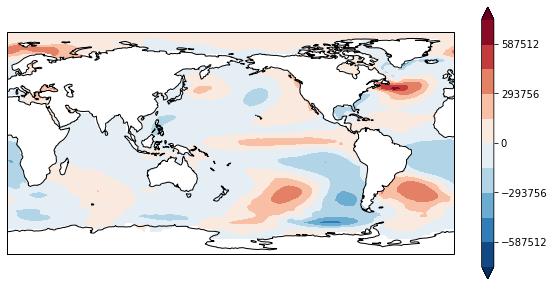

In [29]:
tmp = ds.isel(modes=0).kmodes.values[np.newaxis,:]
z = np.real(tmp) @ pca["EOF"][0:8,:]
z2 = ForceSMIP_ZT_into_XYT(z,data["mask"])
ForceSMIP_plot_map(z2[0,:,:],data)

# Koopman analysis (Polynomial kernel)

In [30]:
%%time
options = {'operator': 'Koopman', 
            'kernel_choice': 'poly',
           'bandwidth': 'std',
           'epsilon': 1e-5}

KK=Koop(X,**options)

Created Koopman Estimator 
 for 1715 samples and 8 features,             1 time interval
CPU times: user 0 ns, sys: 3.62 ms, total: 3.62 ms
Wall time: 3.63 ms


In [31]:
KK.fit(bandwidth='std')

 Calculating Koopman Operator 
Using option std for a  5503.157741683832 and sigma 52.4554941911895

Computed Transfer Eigenvalues


In [32]:
PsiX=KK.PsiX
Gxx=KK.Gxx

ww=KK.ww
vv=KK.vv

In [33]:
# Applicating order_w
w,wt,indw = order_w(ww,option='growth',direction='down')

 Ordering Eigenvalues as  growth  with direction  down


In [34]:
import math

In [35]:
vu=vv[:,indw]

#Order cc 
cc=KK.cc[:,indw]

# Compute modes    
ds = KK.compute_modes(w,vu,modetype='',description='')

Computed Kmodes (1715, 8) for (1715, 1715) normalized eigenfunctions
Computed Kmodes 1715 8 vv  1715 1715 eigenfunctions
Rank of V matrix 496


/ncar/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:431: RuntimeWarning: divide by zero encountered in true_divide


In [36]:
ds

<xarray.Dataset>
Dimensions:  (modes: 1715, time: 1715, x: 8)
Coordinates:
    feature  (x) int64 0 1 2 3 4 5 6 7
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 1708 1709 1710 1711 1712 1713 1714
  * modes    (modes) int64 0 1 2 3 4 5 6 ... 1708 1709 1710 1711 1712 1713 1714
Dimensions without coordinates: x
Data variables:
    kmodes   (x, modes) complex128 (-2.429861068725586-0.0027113347314298153j) ... (-2.1751174926757812-0.5304448287934065j)
    eigfun   (time, modes) complex128 (1.1281692319902845+0j) ... (0.0008744972833483189+0j)
    periods  (modes) float64 inf inf 9.945 -9.945 ... 0.2525 -0.2525 inf 0.1667
    eigval   (modes) complex128 (0.9599605137954892+0j) ... (-4.67910927097898e-09+0j)
Attributes:
    type:         
    description:

In [37]:
ds.isel(modes=0).kmodes.shape

(8,)

In [38]:
ds.isel(modes=0).kmodes

<xarray.DataArray 'kmodes' (x: 8)>
array([ -2.42986107-0.00271133j,  -2.01280594-0.00161155j,
         5.60840845+0.00091609j, -12.3957119 -0.00606337j,
         5.02064228-0.00107251j,   0.07785559-0.00139742j,
         0.34406364-0.00389554j,   1.1395483 +0.00153964j])
Coordinates:
    feature  (x) int64 0 1 2 3 4 5 6 7
    modes    int64 0
Dimensions without coordinates: x

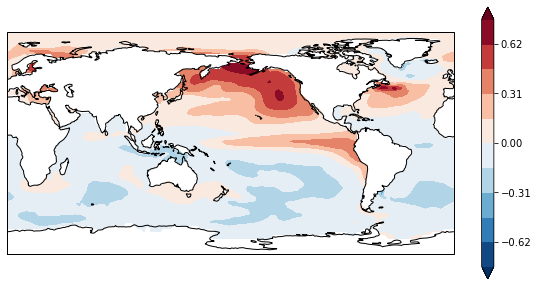

In [42]:
tmp = ds.isel(modes=0).kmodes.values[np.newaxis,:]
z = np.real(tmp) @ pca["EOF"][0:8,:]
z2 = ForceSMIP_ZT_into_XYT(z,data["mask"])
ForceSMIP_plot_map(z2[0,:,:],data)

#### 4. Conclusion

This notebook serves as an example of how LIM approach works in terms of identifying the forced signal. However, there are many other things to consider in LIM, and in the actual scale of the scientific question. For example, we at least need to understand the linear dynamical system that has been constructed. Is it a numerically stable linear system? Can the system reasonably reproduce the lag-covariance statistics of the climate states over lags considerably longer than the training lag, also known as LIM's tau test (see [Penland and Sardeshmukh, 1995](https://journals.ametsoc.org/view/journals/clim/8/8/1520-0442_1995_008_1999_togots_2_0_co_2.xml) or supplementary of [Xu et al, 2021](https://doi.org/10.1029/2020GL090661))? Is the EOF truncation the optimized option, i.e., whether the system is overfitted such that it fails to represent the dynamical system of interest? How sensitive is this approach to the length of the data record? Can we improve upon the LIM approach (e.g., [Solomon and M. Newman, 2012](https://doi.org/10.1038/nclimate1591); [Frankignoul et al, 2017](https://doi.org/10.1175/JCLI-D-17-0009.1); [Wills et al, 2020](https://doi.org/10.1175/JCLI-D-19-0855.1)), and under what scenarios is LIM and LIM-based improvment useful? 

The hackathon provides ensemble realizations for training/validation of the methodology. Can we make use of them to help improve the forced estimate? How to modify the notebook to incoporate the forced estimate identification for all variables of interest? All of the aforementioned considerations are not explored and investigated in this notebook, as this is meant to be a simple coding example. See the LIMopt notebook for a more extensive and comprehensive example.

Thus, please proceed with caution when using this notebook. Feel free to reach out for any questions and suggestions!